# **Data context**

This dataset contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe. Meanwhile, the geographical location of hotels are also provided for further analysis.

*(source: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe?resource=download)*

# **Data content**

The csv file contains 17 fields. The description of each field is as below:

- **Hotel_Address**: Address of hotel.

- **Review_Date**: Date when reviewer posted the corresponding review.

- **Average_Score**: Average Score of the hotel, calculated based on the latest comment in the last year.

- **Hotel_Name**: Name of Hotel.

- **Reviewer_Nationality**: Nationality of Reviewer.

- **Negative_Review**: Negative Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Negative'.

- **ReviewTotalNegativeWordCounts**: Total number of words in the negative review.

- **Positive_Review**: Positive Review the reviewer gave to the hotel. If the reviewer does not give the negative review, then it should be: 'No Positive'.

- **ReviewTotalPositiveWordCounts**: Total number of words in the positive review.

- **Reviewer_Score**: Score the reviewer has given to the hotel, based on his/her experience.

- **TotalNumberofReviewsReviewerHasGiven**: Number of Reviews the reviewers has given in the past.

- **TotalNumberof_Reviews**: Total number of valid reviews the hotel has.

- **Tags**: Tags reviewer gave the hotel.

- **dayssincereview**: Duration between the review date and scrape date.

- **AdditionalNumberof_Scoring**: There are also some guests who just made a scoring on the service rather than a review. This number indicates how many valid scores without review in there.

- **lat**: Latitude of the hotel.

- **lng**: longtitude of the hotel.

*(source: https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe?resource=download)*

# **Installation and imports**

In [1]:
%%capture
!pip install category_encoders
!pip install wordcloud
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install keras_preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline

from datetime import date
import plotly.express as px

from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
import spacy

import category_encoders as ce
from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Flatten, Dropout, BatchNormalization
from keras.layers.core import Dense
from keras import regularizers
import keras
from keras import Model
from keras.layers import Conv1D, GlobalMaxPooling1D, LSTM
import tensorflow as tf

from google.colab import drive

warnings.filterwarnings('ignore')

from joblib import dump, load

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Load the data**

In [4]:
# Due to limited processing units loading only 100000 first rows to make the computations faster
df = pd.read_csv('gdrive/My Drive/Hotel_Reviews.csv')[:100000]

# **EDA**

In [5]:
# Shape of data
df.shape

(100000, 17)

In [6]:
# Unique values in each column
print(df.nunique())

Hotel_Address                                   285
Additional_Number_of_Scoring                    196
Review_Date                                     731
Average_Score                                    28
Hotel_Name                                      285
Reviewer_Nationality                            197
Negative_Review                               66010
Review_Total_Negative_Word_Counts               353
Total_Number_of_Reviews                         261
Positive_Review                               82430
Review_Total_Positive_Word_Counts               267
Total_Number_of_Reviews_Reviewer_Has_Given      143
Reviewer_Score                                   37
Tags                                          14660
days_since_review                               731
lat                                             284
lng                                             284
dtype: int64


In [7]:
# Rows without 'No Negative' in Negative_Review, leave only with content
nn = df[df['Negative_Review'] != 'No Negative']
nn.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968
5,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,Poland,Backyard of the hotel is total mess shouldn t...,17,1403,Good restaurant with modern design great chil...,20,1,6.7,"[' Leisure trip ', ' Group ', ' Duplex Double ...",10 days,52.360576,4.915968


In [8]:
# Rows without 'No Positive' in Positive_Review, leave only with content
pp = df[df['Positive_Review'] != 'No Positive']
pp.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [9]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               100000 non-null  object 
 1   Additional_Number_of_Scoring                100000 non-null  int64  
 2   Review_Date                                 100000 non-null  object 
 3   Average_Score                               100000 non-null  float64
 4   Hotel_Name                                  100000 non-null  object 
 5   Reviewer_Nationality                        100000 non-null  object 
 6   Negative_Review                             100000 non-null  object 
 7   Review_Total_Negative_Word_Counts           100000 non-null  int64  
 8   Total_Number_of_Reviews                     100000 non-null  int64  
 9   Positive_Review                             100000 non-null  object 
 1

In [10]:
# Change column type to datetime for Review_Date
df['Review_Date'] = pd.to_datetime(df['Review_Date'])
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [11]:
#  Basic statistics for numerical columns
df.describe()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,99963.000000,99963.000000
mean,593.559110,8.389596,18.57920,2499.996230,17.309510,6.577550,8.378223,50.985350,0.377099
std,604.204286,0.594723,29.33792,2117.974893,20.928916,10.270083,1.664786,1.061428,1.026726
min,5.000000,6.800000,0.00000,45.000000,0.000000,1.000000,2.500000,48.817808,-0.319292
25%,196.000000,8.000000,2.00000,1016.000000,5.000000,1.000000,7.500000,51.491888,-0.170307
50%,421.000000,8.400000,9.00000,2007.000000,11.000000,3.000000,8.800000,51.502702,-0.125160
75%,728.000000,8.900000,24.00000,2903.000000,22.000000,8.000000,9.600000,51.515052,-0.023221
max,2682.000000,9.800000,401.00000,9086.000000,383.000000,315.000000,10.000000,52.360576,4.915968


In [12]:
# Amount of nan values in all columns
df.isna().sum(axis = 1)

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Length: 100000, dtype: int64

In [13]:
# Amount od null values in all columns
df.isnull().sum()

Hotel_Address                                  0
Additional_Number_of_Scoring                   0
Review_Date                                    0
Average_Score                                  0
Hotel_Name                                     0
Reviewer_Nationality                           0
Negative_Review                                0
Review_Total_Negative_Word_Counts              0
Total_Number_of_Reviews                        0
Positive_Review                                0
Review_Total_Positive_Word_Counts              0
Total_Number_of_Reviews_Reviewer_Has_Given     0
Reviewer_Score                                 0
Tags                                           0
days_since_review                              0
lat                                           37
lng                                           37
dtype: int64

In [14]:
# Drop rows with null values
df = df.dropna(how = 'any', axis = 0)

In [15]:
# Check null values
df.isnull().sum()

Hotel_Address                                 0
Additional_Number_of_Scoring                  0
Review_Date                                   0
Average_Score                                 0
Hotel_Name                                    0
Reviewer_Nationality                          0
Negative_Review                               0
Review_Total_Negative_Word_Counts             0
Total_Number_of_Reviews                       0
Positive_Review                               0
Review_Total_Positive_Word_Counts             0
Total_Number_of_Reviews_Reviewer_Has_Given    0
Reviewer_Score                                0
Tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
dtype: int64

In [16]:
# Retrieve day of week from Review_Date column
df['day'] = df['Review_Date'].dt.day_name()

In [17]:
# Amount of reviews grouped by day of week
occur = df.groupby(['day']).size()
display(occur)

day
Friday        8257
Monday       15551
Saturday      9768
Sunday       16766
Thursday     14128
Tuesday      24147
Wednesday    11346
dtype: int64

In [18]:
# Make one column with overall review
df['review'] = df['Negative_Review'] + df['Positive_Review']

In [19]:
# Get rid of 'No Positive' and 'No Negative' reviews in overall column
df['clean_review'] = df['review'].str.replace("No Negative", "").replace("No Positive", "")

In [20]:
# Country from address
df['country'] = [x.split(' ')[-1] for x in df['Hotel_Address'].values]

In [21]:
# Country from address for 2 new dataframes
pp['country'] = [x.split(' ')[-1] for x in pp['Hotel_Address'].values]
nn['country'] = [x.split(' ')[-1] for x in nn['Hotel_Address'].values]

In [22]:
# Day from date for 2 new columns
pp['Review_Date'] = pd.to_datetime(pp['Review_Date'])
nn['Review_Date'] = pd.to_datetime(nn['Review_Date'])

pp['day'] = pp['Review_Date'].dt.day_name()
nn['day'] = nn['Review_Date'].dt.day_name()

In [23]:
# Group by country and day for data without 'No Positive'
occur = pp.groupby(['country', 'day'], as_index = False).size()
p = pd.DataFrame(occur)
p.rename(columns = {'size': 'without_no_pos_by_day'}, inplace = True)
p

,country,day,without_no_pos_by_day
0,France,Friday,1742
1,France,Monday,2872
2,France,Saturday,1966
3,France,Sunday,2977
4,France,Thursday,2846
5,France,Tuesday,4215
6,France,Wednesday,2126
7,Kingdom,Friday,5855
8,Kingdom,Monday,11437
9,Kingdom,Saturday,7038


In [24]:
# Group by country and day for data without 'No Negative'
occur = nn.groupby(['country', 'day'], as_index = False).size()
n = pd.DataFrame(occur)
n.rename(columns = {'size': 'without_no_neg_by_day'}, inplace = True)
n

,country,day,without_no_neg_by_day
0,France,Friday,1339
1,France,Monday,2204
2,France,Saturday,1527
3,France,Sunday,2261
4,France,Thursday,2123
5,France,Tuesday,3158
6,France,Wednesday,1643
7,Kingdom,Friday,4863
8,Kingdom,Monday,9656
9,Kingdom,Saturday,5914


In [25]:
# Make one datframe from above two
n['without_no_pos_by_day'] = p['without_no_pos_by_day']
n

,country,day,without_no_neg_by_day,without_no_pos_by_day
0,France,Friday,1339,1742
1,France,Monday,2204,2872
2,France,Saturday,1527,1966
3,France,Sunday,2261,2977
4,France,Thursday,2123,2846
5,France,Tuesday,3158,4215
6,France,Wednesday,1643,2126
7,Kingdom,Friday,4863,5855
8,Kingdom,Monday,9656,11437
9,Kingdom,Saturday,5914,7038


In [26]:
# Retrieve columns from dataframe for further visualisation (country)
cc = n[['country', 'without_no_neg_by_day', 'without_no_pos_by_day']]

In [27]:
# Group by country and sum rows
c = cc.groupby(['country'], as_index = False).sum()
c

,country,without_no_neg_by_day,without_no_pos_by_day
0,France,14255,18744
1,Kingdom,61127,73690
2,Netherlands,314,382


In [28]:
# Retrieve columns from dataframe for further visualisation (day)
dd = n[['day', 'without_no_neg_by_day', 'without_no_pos_by_day']]

In [29]:
# Group by day and sum rows
d = dd.groupby(['day'], as_index = False).sum()
d

,day,without_no_neg_by_day,without_no_pos_by_day
0,Friday,6225,7627
1,Monday,11910,14371
2,Saturday,7474,9044
3,Sunday,12601,15588
4,Thursday,10667,13117
5,Tuesday,18167,22544
6,Wednesday,8652,10525


In [30]:
# Group by Reviewer_Nationality for original frame and sum rows
nat = df.groupby(['Reviewer_Nationality'], as_index = False).count()
na = nat[['Reviewer_Nationality', 'Hotel_Address']]
na.rename(columns = {'Hotel_Address':'Amount'}, inplace = True)
na

,Reviewer_Nationality,Amount
0,,95
1,Abkhazia Georgia,27
2,Afghanistan,1
3,Albania,24
4,Algeria,14
...,...,...
192,Venezuela,3
193,Vietnam,35
194,Yemen,3
195,Zambia,8


In [31]:
# Group by Reviewer_Nationality for original frame and sum rows
cou = df.groupby(['Hotel_Name'], as_index = False).count()
co = cou[['Hotel_Name', 'Hotel_Address']]
co.rename(columns = {'Hotel_Address':'Amount'}, inplace = True)
co

,Hotel_Name,Amount
0,11 Cadogan Gardens,159
1,1K Hotel,148
2,Ace Hotel London Shoreditch,514
3,Amarante Champs Elys es,102
4,Ambassadors Bloomsbury,768
...,...,...
279,W London Leicester Square,267
280,Waldorf Madeleine,281
281,Windermere Hotel,95
282,Windsor Opera,34


In [32]:
# Add column to original dataframe with is_weekend status
df['is_weekend'] = df['day'].isin(['Saturday', 'Sunday']).replace(True, 1).replace(False, 0)
df

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,Reviewer_Score,Tags,days_since_review,lat,lng,day,review,clean_review,country,is_weekend
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,...,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Thursday,I am so angry that i made this post available...,I am so angry that i made this post available...,Netherlands,0
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,...,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Thursday,No Negative No real complaints the hotel was g...,No real complaints the hotel was great great ...,Netherlands,0
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,...,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,Monday,Rooms are nice but for elderly a bit difficul...,Rooms are nice but for elderly a bit difficul...,Netherlands,0
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,...,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,Monday,My room was dirty and I was afraid to walk ba...,My room was dirty and I was afraid to walk ba...,Netherlands,0
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,...,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,Monday,You When I booked with your company on line y...,You When I booked with your company on line y...,Netherlands,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,20 Rue Jean Rey 15th arr 75015 Paris France,333,2017-03-27,8.0,Mercure Paris Centre Tour Eiffel,United States of America,No Negative,0,2611,Great location good service spoke good Englis...,...,8.3,"[' Leisure trip ', ' Family with young childre...",129 day,48.854864,2.292318,Monday,No Negative Great location good service spoke ...,Great location good service spoke good Englis...,France,0
99996,20 Rue Jean Rey 15th arr 75015 Paris France,333,2017-03-27,8.0,Mercure Paris Centre Tour Eiffel,Estonia,No Negative,0,2611,Good and silent hotel location super Close to...,...,10.0,"[' Leisure trip ', ' Couple ', ' Privilege Roo...",129 day,48.854864,2.292318,Monday,No Negative Good and silent hotel location sup...,Good and silent hotel location super Close to...,France,0
99997,20 Rue Jean Rey 15th arr 75015 Paris France,333,2017-03-18,8.0,Mercure Paris Centre Tour Eiffel,United Kingdom,Small room and no bath for a 4 star hotel,11,2611,View of Tower from room,...,6.7,"[' Business trip ', ' Couple ', ' Standard Dou...",138 day,48.854864,2.292318,Saturday,Small room and no bath for a 4 star hotel Vie...,Small room and no bath for a 4 star hotel Vie...,France,1
99998,20 Rue Jean Rey 15th arr 75015 Paris France,333,2017-03-17,8.0,Mercure Paris Centre Tour Eiffel,Finland,No Negative,0,2611,Bose loudspeaker in the room,...,7.1,"[' Business trip ', ' Solo traveler ', ' Privi...",139 day,48.854864,2.292318,Friday,No Negative Bose loudspeaker in the room,Bose loudspeaker in the room,France,0


In [33]:
# Columns in original dataframe with some added previously
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng', 'day', 'review', 'clean_review',
       'country', 'is_weekend'],
      dtype='object')

In [34]:
# Amount of reviews for each month
rev_date = df.groupby(pd.Grouper(key='Review_Date', axis=0, freq='M')).size()
dates = pd.DataFrame(rev_date)
dates

,0
Review_Date,
2015-08-31,3895
2015-09-30,3869
2015-10-31,3855
2015-11-30,3663
2015-12-31,3751
2016-01-31,4263
2016-02-29,4323
2016-03-31,4245
2016-04-30,4416


<Axes: >

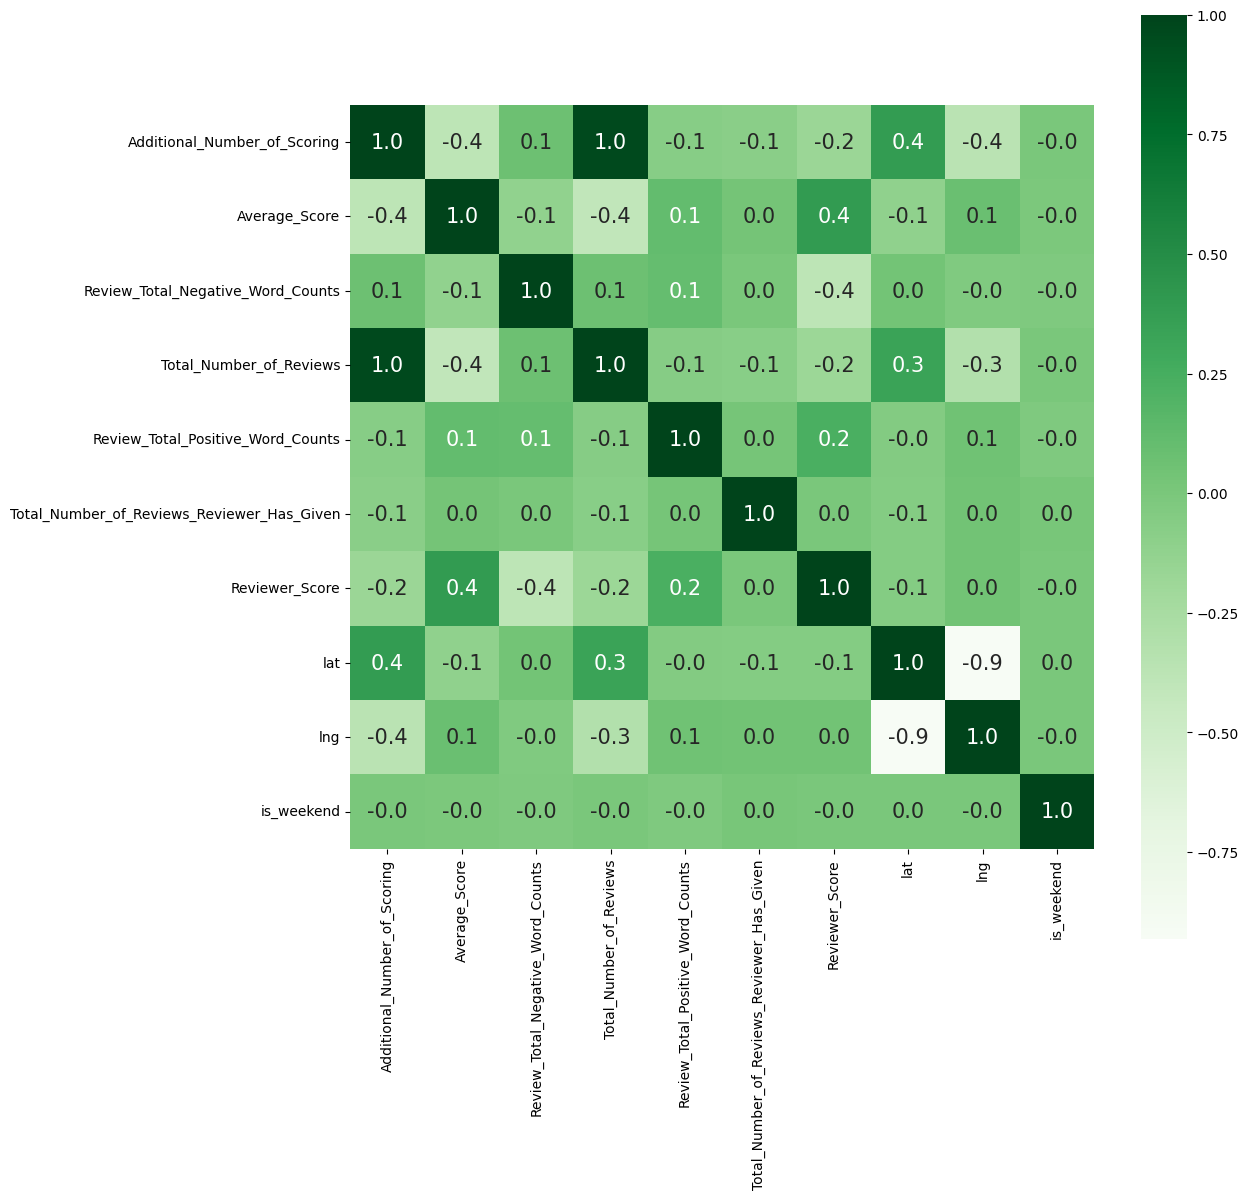

In [35]:
# Correlation matrix before transformations
plt.figure(figsize=(12,12))
count_corr = df.corr()
sns.heatmap(count_corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

# **Visualization**

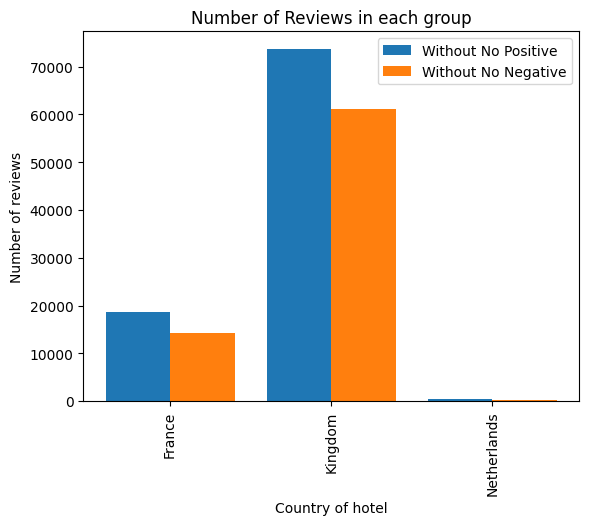

In [36]:
# Amount of positive and negative reviews separately depends on Hotel Country (most reviews from United Kingdom)
X = c['country']
Y = c['without_no_pos_by_day']
Z = c['without_no_neg_by_day']

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Y, 0.4, label = 'Without No Positive')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Without No Negative')

plt.xticks(X_axis, X, rotation = 'vertical')
plt.xlabel("Country of hotel")
plt.ylabel("Number of reviews")
plt.title("Number of Reviews in each group")
plt.legend()
plt.show()

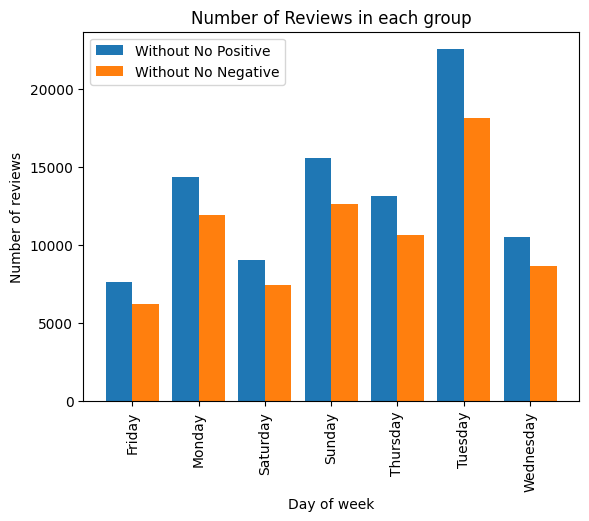

In [37]:
# Amount of positive and negative reviews separately depends on Day of week (most reviews made on Tuesday)
X = d['day']
Y = d['without_no_pos_by_day']
Z = d['without_no_neg_by_day']

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, Y, 0.4, label = 'Without No Positive')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Without No Negative')

plt.xticks(X_axis, X, rotation = 'vertical')
plt.xlabel("Day of week")
plt.ylabel("Number of reviews")
plt.title("Number of Reviews in each group")
plt.legend()
plt.show()

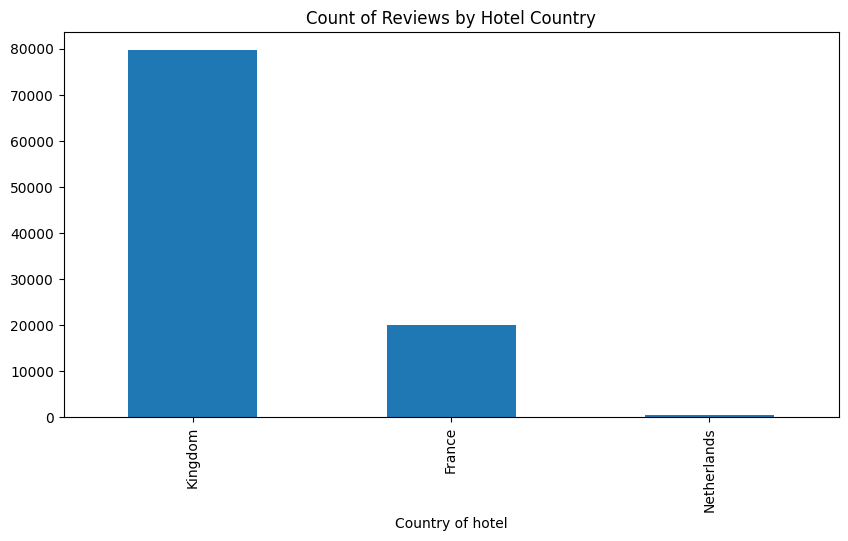

In [38]:
# Amount of reviews depends on Hotel Country (most reviews from United Kingdom)
ax = df['country'].value_counts()\
    .plot(kind='bar',
          title='Count of Reviews by Hotel Country',
          figsize=(10, 5))
ax.set_xlabel('Country of hotel')
plt.show()

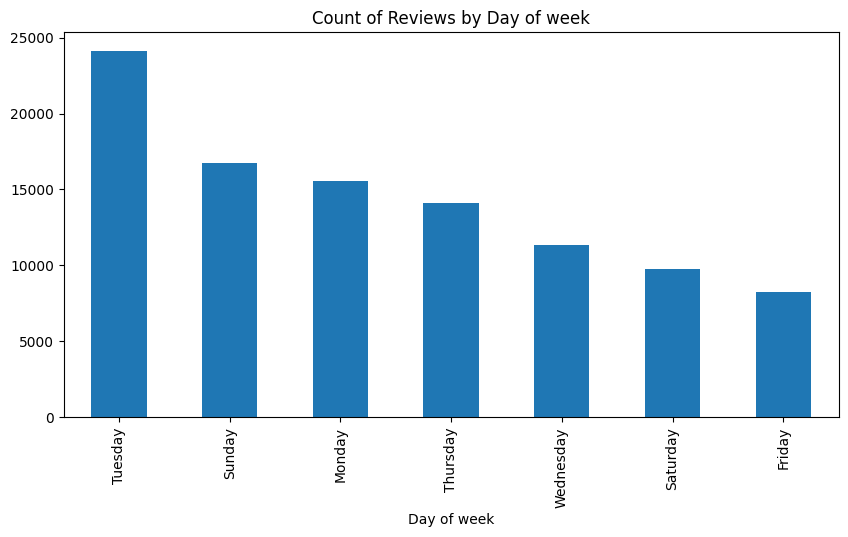

In [39]:
# Amount of reviews depends on Day of week (most reviews made on Tuesday)
ax = df['day'].value_counts() \
    .plot(kind='bar',
          title='Count of Reviews by Day of week',
          figsize=(10, 5))
ax.set_xlabel('Day of week')
plt.show()

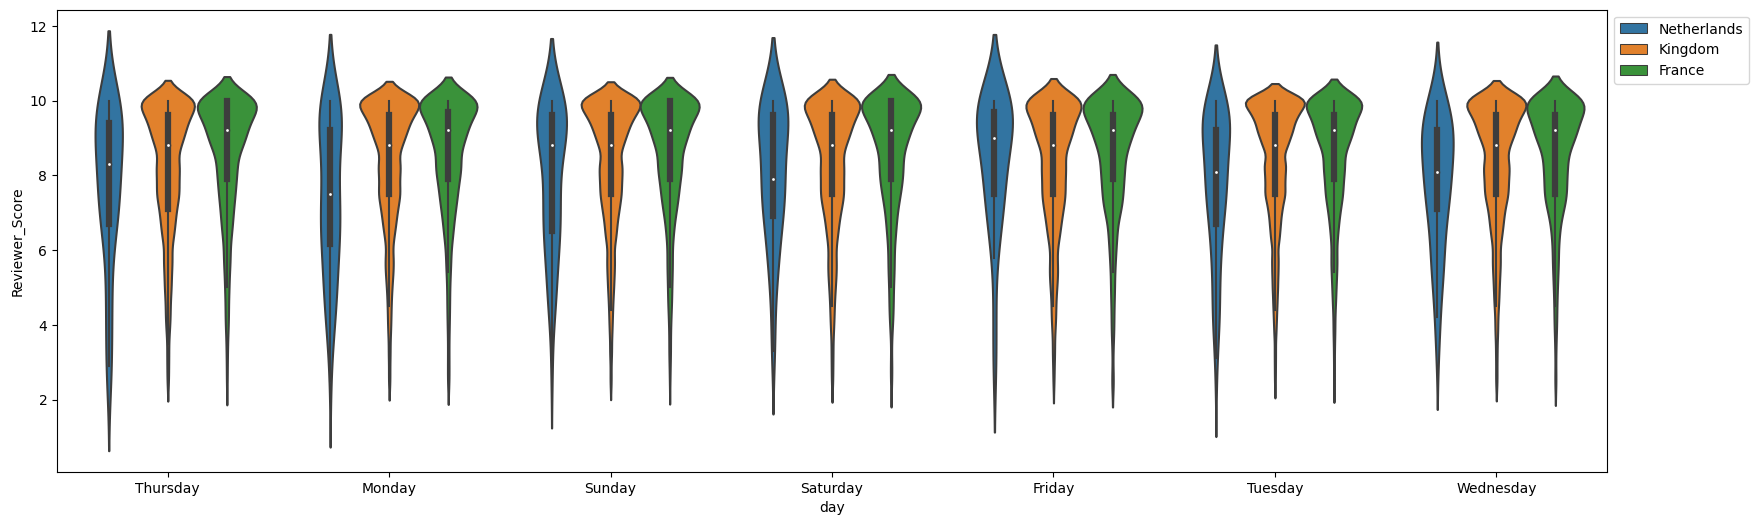

In [40]:
# Violin plot with Reviewer_Score, day of week and country of hotel (small discrepancies between countries and day of week)
plt.figure(figsize=(20,6))
v = sns.violinplot(x='day', y='Reviewer_Score', data=df, hue='country')
plt.legend(loc=2, bbox_to_anchor=(1,1))

# **Sentiment Analysis**

In [41]:
# Remove short words from nn with no 'No_Negative' in Negative_Review
nn = nn.dropna(how = 'any', axis = 0)
not_neg = nn['Negative_Review'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
not_neg.head()

0    angry that made this post available possible s...
2    Rooms nice elderly difficult most rooms story ...
3    room dirty afraid walk barefoot floor which lo...
4    When booked with your company line showed pict...
5    Backyard hotel total mess shouldn happen hotel...
Name: Negative_Review, dtype: object

In [42]:
# Individual words considered as tokens for above
tokenized_review_n = not_neg.apply(lambda x: x.split())
tokenized_review_n.head()

0    [angry, that, made, this, post, available, pos...
2    [Rooms, nice, elderly, difficult, most, rooms,...
3    [room, dirty, afraid, walk, barefoot, floor, w...
4    [When, booked, with, your, company, line, show...
5    [Backyard, hotel, total, mess, shouldn, happen...
Name: Negative_Review, dtype: object

In [43]:
# Stem the words for above (root)
stemmer_n = PorterStemmer()

stem_review_n = tokenized_review_n.apply(lambda sentence: [stemmer_n.stem(word) for word in sentence])
stem_review_n.head()

0    [angri, that, made, thi, post, avail, possibl,...
2    [room, nice, elderli, difficult, most, room, s...
3    [room, dirti, afraid, walk, barefoot, floor, w...
4    [when, book, with, your, compani, line, show, ...
5    [backyard, hotel, total, mess, shouldn, happen...
Name: Negative_Review, dtype: object

In [44]:
# One sentence for above words
sen_review_n = stem_review_n.apply(lambda x: ' '.join(x))
sen_review_n

0        angri that made thi post avail possibl site wh...
2        room nice elderli difficult most room stori wi...
3        room dirti afraid walk barefoot floor which lo...
4        when book with your compani line show pictur r...
5        backyard hotel total mess shouldn happen hotel...
                               ...                        
99991                                     room small there
99993    separ toilet like between bathroom standard ot...
99994              toilet seper need extractor veri stuffi
99997                           small room bath star hotel
99999                                    enough view tower
Name: Negative_Review, Length: 75670, dtype: object

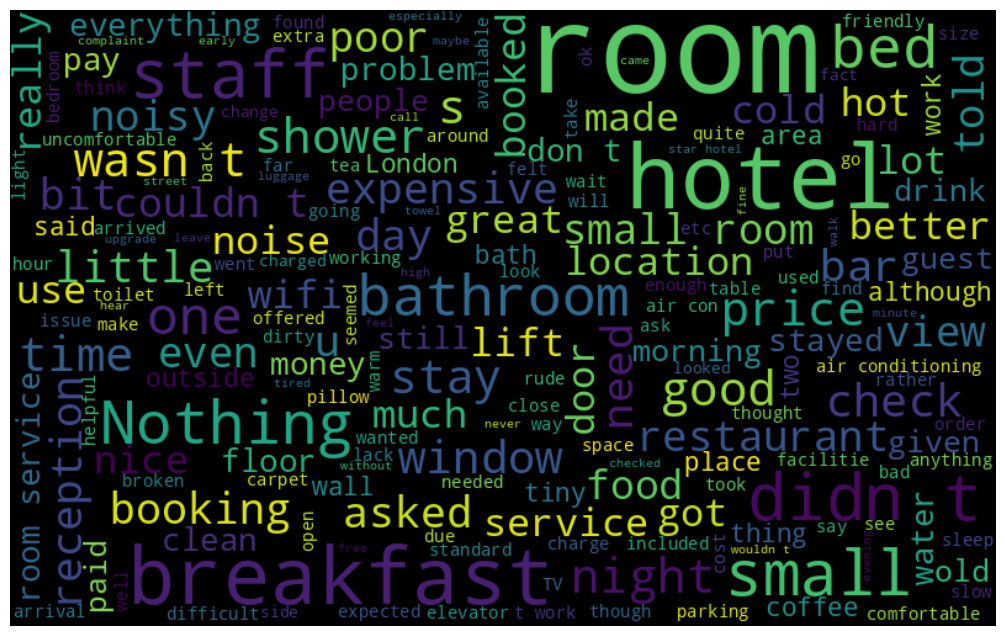

In [45]:
# Visualize the frequence of negative words
neg_words = " ".join([sentence for sentence in nn['Negative_Review']])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(neg_words)

# Plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [46]:
# Remove short words from pp with no 'No_Positive' in Positive_Review
pp = pp.dropna(how = 'any', axis = 0)
not_pos = pp['Positive_Review'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
not_pos.head()

0                    Only park outside hotel beautiful
1    real complaints hotel great great location sur...
2    Location good staff were cute hotel breakfast ...
3    Great location nice surroundings restaurant ni...
4           Amazing location building Romantic setting
Name: Positive_Review, dtype: object

In [47]:
# Individual words considered as tokens for above
tokenized_review_p = pp['Positive_Review'].apply(lambda x: x.split())
tokenized_review_p.head()

0    [Only, the, park, outside, of, the, hotel, was...
1    [No, real, complaints, the, hotel, was, great,...
2    [Location, was, good, and, staff, were, ok, It...
3    [Great, location, in, nice, surroundings, the,...
4    [Amazing, location, and, building, Romantic, s...
Name: Positive_Review, dtype: object

In [48]:
# Stem the words for above (root)
stemmer_p = PorterStemmer()

stem_review_p = tokenized_review_p.apply(lambda sentence: [stemmer_p.stem(word) for word in sentence])
stem_review_p.head()

0    [onli, the, park, outsid, of, the, hotel, wa, ...
1    [no, real, complaint, the, hotel, wa, great, g...
2    [locat, wa, good, and, staff, were, ok, it, is...
3    [great, locat, in, nice, surround, the, bar, a...
4               [amaz, locat, and, build, romant, set]
Name: Positive_Review, dtype: object

In [49]:
# One sentence for above words
sen_review_p = stem_review_p.apply(lambda x: ' '.join(x))
sen_review_p

0              onli the park outsid of the hotel wa beauti
1        no real complaint the hotel wa great great loc...
2        locat wa good and staff were ok it is cute hot...
3        great locat in nice surround the bar and resta...
4                          amaz locat and build romant set
                               ...                        
99995    great locat good servic spoke good english hel...
99996    good and silent hotel locat super close to eiffel
99997                              view of tower from room
99998                           bose loudspeak in the room
99999                                                staff
Name: Positive_Review, Length: 92783, dtype: object

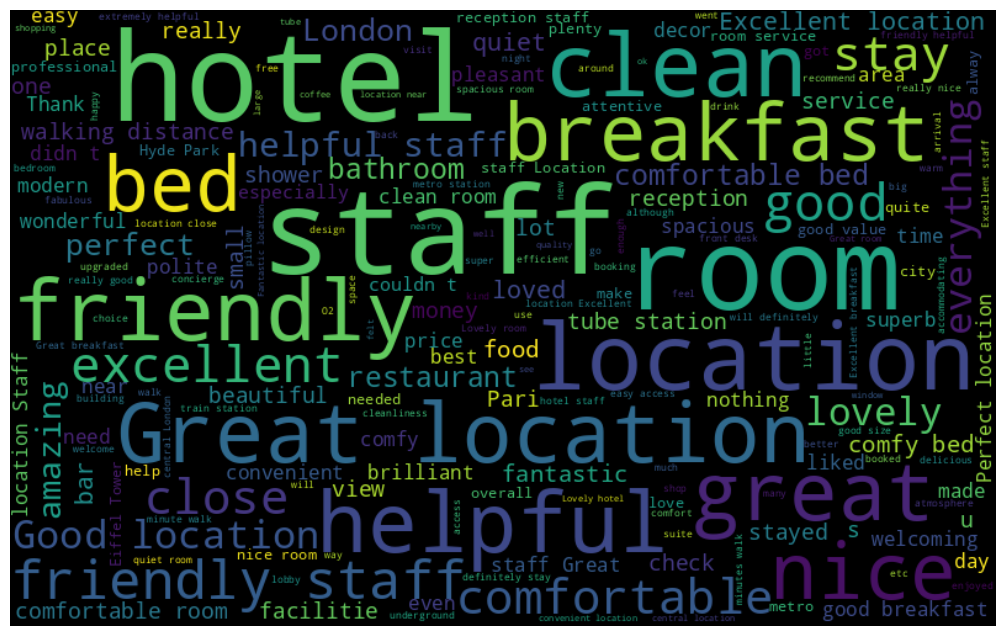

In [50]:
# Visualize the frequence of positive words
pos_words = " ".join([sentence for sentence in pp['Positive_Review']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(pos_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [51]:
# Remove short words from clean_review for all data
cr = df['clean_review'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
cr.head()

0    angry that made this post available possible s...
1    real complaints hotel great great location sur...
2    Rooms nice elderly difficult most rooms story ...
3    room dirty afraid walk barefoot floor which lo...
4    When booked with your company line showed pict...
Name: clean_review, dtype: object

In [52]:
# Individual words considered as tokens for above
tokenized_review = cr.apply(lambda x: x.split())
tokenized_review.head()

0    [angry, that, made, this, post, available, pos...
1    [real, complaints, hotel, great, great, locati...
2    [Rooms, nice, elderly, difficult, most, rooms,...
3    [room, dirty, afraid, walk, barefoot, floor, w...
4    [When, booked, with, your, company, line, show...
Name: clean_review, dtype: object

In [53]:
# Stem the words for above (root)
stemmer = PorterStemmer()

stem_review= tokenized_review.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
stem_review.head()

0    [angri, that, made, thi, post, avail, possibl,...
1    [real, complaint, hotel, great, great, locat, ...
2    [room, nice, elderli, difficult, most, room, s...
3    [room, dirti, afraid, walk, barefoot, floor, w...
4    [when, book, with, your, compani, line, show, ...
Name: clean_review, dtype: object

In [54]:
# One sentence for above words
sen_review = stem_review.apply(lambda x: ' '.join(x))
sen_review

0        angri that made thi post avail possibl site wh...
1        real complaint hotel great great locat surroun...
2        room nice elderli difficult most room stori wi...
3        room dirti afraid walk barefoot floor which lo...
4        when book with your compani line show pictur r...
                               ...                        
99995    great locat good servic spoke good english hel...
99996           good silent hotel locat super close eiffel
99997      small room bath star hotel view tower from room
99998                                  bose loudspeak room
99999                              enough view tower staff
Name: clean_review, Length: 99963, dtype: object

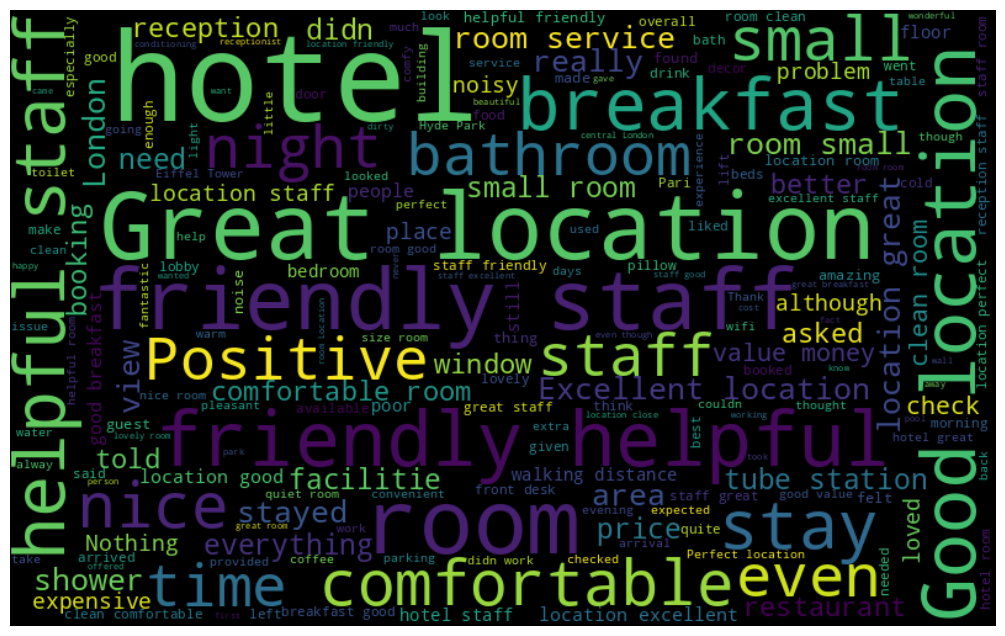

In [55]:
# Visualize the frequence of all words
words = " ".join([sentence for sentence in cr])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [56]:
nlp = spacy.load("en_core_web_sm")

In [57]:
# One sentence for tokenized words
sen_tok_review = tokenized_review.apply(lambda x: ' '.join(x))

In [58]:
rev_small = sen_tok_review[:50000]

In [59]:
# Tokenized words with nlp
tab = []
for i in range(len(rev_small)):
  tab.append(nlp(rev_small[i]))

In [60]:
# NER with table of words and label
tab_text = []
tab_label = []
for i in range(len(tab)):
  for word in tab[i].ents:
    tab_text.append(word.text)
    tab_label.append(word.label_)

In [61]:
tab_pos = []
tab_word = []
for i in tab:
   for token in i:
     tab_pos.append(token.pos_)
     tab_word.append(token.text)

In [62]:
# Dataframe with words and labels
words = pd.DataFrame()
words['Word'] = tab_text
words['Label'] = tab_label

In [63]:
# Group label for all words
wor = words.groupby(['Label'], as_index = False).count()
wor.rename(columns = {'Word':'Amount'}, inplace = True, index = wor['Label'])
wo = pd.DataFrame(wor).sort_values(by = 'Amount')
w = wo.drop(columns = 'Label')
w

,Amount
MONEY,22
LAW,37
EVENT,86
QUANTITY,108
WORK_OF_ART,385
LANGUAGE,573
PRODUCT,1165
CARDINAL,1267
LOC,2109
NORP,2158


In [64]:
# Dataframe with selected words and part of speech
pos = pd.DataFrame()
pos['Word'] = tab_word
pos['Pos'] = tab_pos

In [65]:
# Group pos for selected words
po = pos.groupby(['Pos'], as_index = False).count()
po.rename(columns = {'Word':'Amount'}, inplace = True, index = po['Pos'])
po = pd.DataFrame(po).sort_values(by = 'Amount')
p1 = po.drop(columns = 'Pos')
p1

,Amount
PUNCT,43
X,122
CCONJ,771
PART,887
INTJ,1311
NUM,1602
DET,12060
SCONJ,15698
PRON,32966
AUX,39208


In [66]:
# One sentence for tokenized negative words
sen_tok_review_n = tokenized_review_n.apply(lambda x: ' '.join(x).lower())

In [67]:
idx = pd.Index(range(0, len(sen_tok_review_n), 1))
sen_tok_review_n_ = sen_tok_review_n.set_axis(idx)

In [68]:
# Tokenized negative words with nlp
tab_n = []
for i in range(len(sen_tok_review_n_)):
  tab_n.append(nlp(sen_tok_review_n_[i]))

In [69]:
# NER with table of words and label for negative words
tab_text_n = []
tab_label_n = []
for i in range(len(tab_n)):
  for word in tab_n[i].ents:
    tab_text_n.append(word.text)
    tab_label_n.append(word.label_)

In [70]:
# Dataframe with words and labels for negative
words_n = pd.DataFrame()
words_n['Word'] = tab_text_n
words_n['Label'] = tab_label_n

In [71]:
# Group label for negative words
wor_n = words_n.groupby(['Label'], as_index = False).count()
wor_n.rename(columns = {'Word':'Amount'}, inplace = True)
wo_n = pd.DataFrame(wor_n).sort_values(by = 'Amount')
wo_n

,Label,Amount
12,PERCENT,1
6,LAW,6
2,EVENT,7
8,MONEY,17
14,PRODUCT,18
17,WORK_OF_ART,18
7,LOC,122
15,QUANTITY,144
3,FAC,189
5,LANGUAGE,297


In [72]:
# One sentence for tokenized positive words
sen_tok_review_p = tokenized_review_p.apply(lambda x: ' '.join(x).lower())

In [73]:
idx = pd.Index(range(0, len(sen_tok_review_p), 1))
sen_tok_review_p_ = sen_tok_review_p.set_axis(idx)

In [74]:
# Tokenized positive words with nlp
tab_p = []
for i in range(len(sen_tok_review_p_)):
  tab_p.append(nlp(sen_tok_review_p_[i]))

In [75]:
# NER with table of words and label for positive words
tab_text_p = []
tab_label_p = []
for i in range(len(tab_p)):
  for word in tab_p[i].ents:
    tab_text_p.append(word.text)
    tab_label_p.append(word.label_)

In [76]:
# Dataframe with words and labels for positive
words_p = pd.DataFrame()
words_p['Word'] = tab_text_p
words_p['Label'] = tab_label_p

In [77]:
# Group label for positive words
wor_p = words_p.groupby(['Label'], as_index = False).count()
wor_p.rename(columns = {'Word':'Amount'}, inplace = True)
wo_p = pd.DataFrame(wor_p).sort_values(by = 'Amount')
wo_p

,Label,Amount
12,PERCENT,5
17,WORK_OF_ART,6
2,EVENT,7
6,LAW,20
14,PRODUCT,42
8,MONEY,44
7,LOC,260
5,LANGUAGE,311
15,QUANTITY,355
9,NORP,1557


# **Data preprocessing**

In [78]:
# Retrieving the columns which will be considered and setting independent/dependent variables
df1 = df[['Hotel_Name', 'Reviewer_Nationality', 'lat', 'lng', 'clean_review', 'day', 'country', 'Reviewer_Score']]
# Reviewer Score column will be dropped from X1 set later
X1 = df1[['Hotel_Name', 'Reviewer_Nationality', 'lat', 'lng', 'day', 'country', 'Reviewer_Score']]
X2 = sen_review
y = df1[['Reviewer_Score']]

In [79]:
# Correlation for chosen numeric columns
count_corr = df1.corr()
px.imshow(count_corr, text_auto=True, color_continuous_scale='blues')

In [80]:
# Train-test split
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, shuffle=True, random_state=111)

In [81]:
# OHE for columns: country i day for X1_train and X1_test sets
ohe_X1_train = pd.get_dummies(X1_train, columns = ['day', 'country'])
ohe_X1_test = pd.get_dummies(X1_test, columns = ['day', 'country'])
ohe_X1_test

,Hotel_Name,Reviewer_Nationality,lat,lng,Reviewer_Score,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,country_France,country_Kingdom,country_Netherlands
49321,Hotel Op ra Richepanse,United Arab Emirates,48.868693,2.325211,10.0,0,0,0,0,1,0,0,1,0,0
9571,Grand Royale London Hyde Park,Canada,51.510995,-0.186342,8.3,0,0,0,0,1,0,0,0,1,0
25812,Ace Hotel London Shoreditch,Australia,51.525416,-0.077285,7.5,0,0,0,0,0,0,1,0,1,0
27311,The Grosvenor,United Kingdom,51.495666,-0.145279,10.0,0,0,1,0,0,0,0,0,1,0
30495,The Kensington Hotel,Canada,51.492548,-0.178061,8.8,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81085,Hotel The Peninsula Paris,Saudi Arabia,48.871060,2.293354,10.0,0,0,0,0,0,1,0,1,0,0
30798,Holiday Inn London Stratford City,United Kingdom,51.542605,-0.007271,3.3,0,1,0,0,0,0,0,0,1,0
75136,Park Plaza London Riverbank,United Kingdom,51.491374,-0.121419,5.0,0,0,0,1,0,0,0,0,1,0
96428,citizenM London Bankside,United Kingdom,51.505151,-0.100472,10.0,0,0,0,0,0,0,1,0,1,0


In [82]:
# TE for columns: Reviewer_Nationality and Hotel_Name for X1_train and X1_test sets
mean_rev_nat_X1_train = ohe_X1_train.groupby('Reviewer_Nationality')['Reviewer_Score'].mean().to_dict()
mean_rev_nat_X1_test = ohe_X1_test.groupby('Reviewer_Nationality')['Reviewer_Score'].mean().to_dict()
mean_rev_nat_X1_train

{' ': 7.839240506329113,
 ' Abkhazia Georgia ': 8.056521739130435,
 ' Albania ': 7.984210526315789,
 ' Algeria ': 8.11,
 ' Andorra ': 9.0,
 ' Angola ': 8.3,
 ' Antigua Barbuda ': 7.342857142857143,
 ' Argentina ': 8.334615384615384,
 ' Armenia ': 8.333333333333334,
 ' Aruba ': 8.633333333333333,
 ' Australia ': 8.49250295159386,
 ' Austria ': 8.41924882629108,
 ' Azerbaijan ': 8.162962962962963,
 ' Bahamas ': 8.585714285714285,
 ' Bahrain ': 8.048214285714286,
 ' Bangladesh ': 8.180952380952382,
 ' Barbados ': 8.34375,
 ' Belarus ': 7.688888888888889,
 ' Belgium ': 8.20572472594397,
 ' Belize ': 9.399999999999999,
 ' Benin ': 9.6,
 ' Bermuda ': 8.733333333333333,
 ' Bhutan ': 8.8,
 ' Bosnia and Herzegovina ': 8.639999999999999,
 ' Botswana ': 9.033333333333333,
 ' Brazil ': 8.550943396226415,
 ' British Virgin Islands ': 10.0,
 ' Brunei ': 8.342857142857142,
 ' Bulgaria ': 7.992857142857143,
 ' Burundi ': 8.8,
 ' Cambodia ': 8.633333333333333,
 ' Cameroon ': 10.0,
 ' Canada ': 8.477458

In [83]:
mean_hot_nam_X1_train = ohe_X1_train.groupby('Hotel_Name')['Reviewer_Score'].mean().to_dict()
mean_hot_nam_X1_test = ohe_X1_test.groupby('Hotel_Name')['Reviewer_Score'].mean().to_dict()
mean_hot_nam_X1_train

{'11 Cadogan Gardens': 8.951639344262293,
 '1K Hotel': 7.790825688073395,
 'Ace Hotel London Shoreditch': 8.692620865139949,
 'Amarante Champs Elys es': 7.5894736842105255,
 'Ambassadors Bloomsbury': 7.882352941176471,
 'Amp re': 8.829787234042554,
 'Apex Temple Court Hotel': 9.3273276904474,
 'Arbor City': 8.90015625,
 'Ashburn Hotel': 8.713297872340425,
 'Atala Champs Elys es': 8.027999999999999,
 'Au Manoir Saint Germain': 8.723770491803279,
 'Bassano': 8.19875,
 'Batty Langley s': 9.3752688172043,
 'Belfast': 7.758333333333334,
 'Best Western Ducs de Bourgogne': 7.385964912280702,
 'Best Western Mercedes Arc de Triomphe': 8.084782608695651,
 'Best Western Mornington Hotel Hyde Park': 7.97797619047619,
 'Best Western Op ra Batignolles': 7.554430379746835,
 'Best Western Paris Gare Saint Lazare': 7.303174603174604,
 'Best Western Premier Le Swann': 7.957894736842104,
 'Best Western Premier Louvre Saint Honor ': 8.366071428571429,
 'Best Western Premier Marais Grands Boulevards': 8.27

In [84]:
ohe_X1_train['Reviewer_Nationality'] = ohe_X1_train['Reviewer_Nationality'].map(mean_rev_nat_X1_train)
ohe_X1_test['Reviewer_Nationality'] = ohe_X1_test['Reviewer_Nationality'].map(mean_rev_nat_X1_test)
ohe_X1_train['Hotel_Name'] = ohe_X1_train['Hotel_Name'].map(mean_hot_nam_X1_train)
ohe_X1_test['Hotel_Name'] = ohe_X1_test['Hotel_Name'].map(mean_hot_nam_X1_test)

In [85]:
ohe_X1_train.head()

,Hotel_Name,Reviewer_Nationality,lat,lng,Reviewer_Score,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,country_France,country_Kingdom,country_Netherlands
2744,7.730057,8.374648,51.514218,-0.180903,8.8,0,0,0,0,0,1,0,0,1,0
26428,8.356323,8.448291,51.495666,-0.145279,10.0,0,0,0,0,0,1,0,0,1,0
7884,8.374176,8.175934,48.848768,2.341038,7.1,0,0,1,0,0,0,0,1,0,0
25378,7.943280,8.746157,51.492514,-0.178792,7.1,0,0,0,1,0,0,0,0,1,0
68389,6.840272,8.448291,51.501910,-0.023221,7.5,0,0,0,1,0,0,0,0,1,0


In [86]:
# Drop 'Reviewer_Score' column from ohe_X1_train and ohe_X1_test
X1_test_prepared = ohe_X1_test.drop(columns = 'Reviewer_Score')
X1_train_prepared = ohe_X1_train.drop(columns = 'Reviewer_Score')

In [87]:
# Scaler for other numerical data: Hotel_Name, Reviewer_Nationality, lat, lng (only for train set)
X1_train_prepared[['Hotel_Name','lat','lng','Reviewer_Nationality']] = MinMaxScaler().fit_transform(X1_train_prepared[['Hotel_Name','lat','lng','Reviewer_Nationality']])
X1_train_prepared.head()

,Hotel_Name,Reviewer_Nationality,lat,lng,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,country_France,country_Kingdom,country_Netherlands
2744,0.470843,0.783286,0.761103,0.026434,0,0,0,0,0,1,0,0,1,0
26428,0.627906,0.793105,0.755866,0.033239,0,0,0,0,0,1,0,0,1,0
7884,0.632383,0.756791,0.008739,0.508156,0,0,1,0,0,0,0,1,0,0
25378,0.524318,0.832821,0.754976,0.026837,0,0,0,1,0,0,0,0,1,0
68389,0.247692,0.793105,0.757628,0.056553,0,0,0,1,0,0,0,0,1,0


# **Modelling - preparation**

In [88]:
# To categorical target variable y
prepared_y_test = to_categorical(y_test)
prepared_y_train = to_categorical(y_train)
print(pd.DataFrame(prepared_y_test))

        0    1    2    3    4    5    6    7    8    9    10
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
19988  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
19989  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
19990  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
19991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
19992  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0

[19993 rows x 11 columns]


In [89]:
X2_train.head()

2744     excel locat staff were veri warm welcom help p...
26428    told couldn gourmet societi card meal when ref...
7884     there strang sound whole night mayb heat oder ...
25378                            wifi room locat room size
68389    lift queue down breakfast veri pack breakfast ...
Name: clean_review, dtype: object

In [90]:
X2_test.head()

49321                     breakfast expens everyth perfect
9571     littl expens averag travel were last minut boo...
25812    found staff recept where littl hard cool most ...
27311    have dislik veri easi check room veri comfort ...
30495    staff were friendli help public space were lov...
Name: clean_review, dtype: object

In [91]:
max_features = 10000
word_tokenizer = Tokenizer(num_words=max_features)
word_tokenizer.fit_on_texts(X2_train)

X2_train_tok = word_tokenizer.texts_to_sequences(X2_train)
X2_test_tok = word_tokenizer.texts_to_sequences(X2_test)

In [92]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

20064

In [93]:
# Padding all reviews to fixed length 100 and setting the amount of input tokens to 10000
maxlen = 100

X2_train_pad = pad_sequences(X2_train_tok, padding = 'post', maxlen=maxlen)
X2_test_pad = pad_sequences(X2_test_tok, padding = 'post', maxlen=maxlen)

In [94]:
def model_transform(mod, name):

  # Model compilation
  mod.compile(loss = "binary_crossentropy", optimizer='adam', metrics = ['accuracy'])

  # Model summary
  mod.summary()

  # Model history
  history = mod.fit(x = [X1_train_prepared, X2_train_pad], y = prepared_y_train, epochs = 10, verbose = 1, validation_split = 0.2)

  # Predictions on test set
  score = mod.evaluate(x = [X1_test_prepared, X2_test_pad], y = prepared_y_test, verbose = 1)
  print()

  # Model performance
  print("Test Score:", score[0])
  print("Test Acc:", score[1])

  # Model evaluation graph
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(accuracy))
  ax = plt.axes()
  ax.set_facecolor('white')
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  ax = plt.axes()
  ax.set_facecolor('white')
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

  # Evaluation on test set
  print()
  test_predictions = mod.predict(x = [X1_test_prepared, X2_test_pad])
  odp_pred = np.argmax(test_predictions, axis = 1)
  count = pd.Series(odp_pred).value_counts()
  print("Element Count")
  print(count)
  y_pred = test_predictions.argmax(axis=1)
  y_test = np.array([elem.argmax(axis=0) for elem in prepared_y_test])

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_pred, y_test, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

  sns.set(rc={'figure.figsize':(11.7,8.27)})
  ax = sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
  ax.set(xlabel="Predicted labels", ylabel="True labels")
  ax.set(title="Confusion matrix")

  # Save model for future prediction
  dump(mod, name+'.joblib')

# **Models**

# Model 1 - simple neural network

In [ ]:
# Architecture
model1 = Sequential()
model1.add(Dense(16, activation="relu", input_shape = (X1_train_prepared.shape[1], )))
model1.add(Dense(8, activation="relu"))
model1.add(Flatten())

model2 = Sequential()
embedding_layer = Embedding(max_features, 16, input_length = maxlen, trainable = True)
model2.add(embedding_layer)
model2.add(Dense(16, activation="relu"))
model2.add(Flatten())

combinedInput = keras.layers.concatenate([model1.output, model2.output])
x = Dense(8, activation="relu")(combinedInput)
x = Dense(11, activation="softmax")(x)
model_1 = Model(inputs=[model1.input, model2.input], outputs = x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_input (InputLayer)       [(None, 14)]         0           []                               
                                                                                                  
 embedding_input (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           240         ['dense_input[0][0]']            
                                                                                                  
 embedding (Embedding)          (None, 100, 16)      160000      ['embedding_input[0][0]']        
                                                                                              

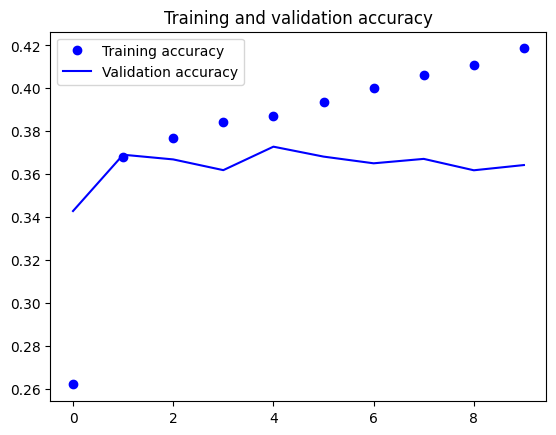

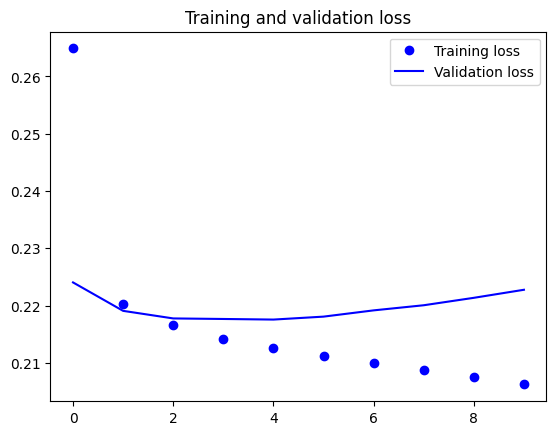


625/625 [==============================] - 1s 2ms/step
Element Count
10    19960
9        32
8         1
dtype: int64


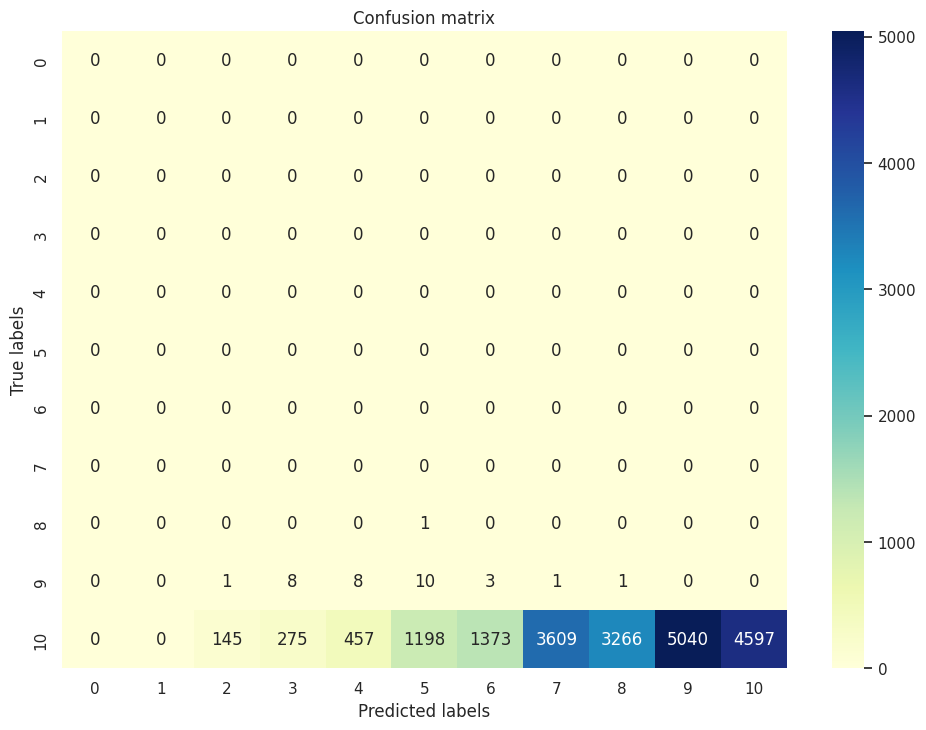

In [ ]:
model_transform(model_1, 'Simple_neural_network')

# Model 2 - dropout and different number of neurons

In [ ]:
# Architecture
model3 = Sequential()
model3.add(Dense(8, activation="relu", input_shape = (X1_train_prepared.shape[1], )))
model3.add(Dense(4, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Flatten())

model4 = Sequential()
embedding_layer = Embedding(max_features, 4, input_length = maxlen, trainable = True)
model4.add(embedding_layer)
model4.add(Dense(8, activation="relu"))
model4.add(Dropout(0.2))
model4.add(Flatten())

combinedInput = keras.layers.concatenate([model3.output, model4.output])
x = Dense(4, activation="relu")(combinedInput)
x = Dense(11, activation="softmax")(x)
model_2 = Model(inputs=[model3.input, model4.input], outputs = x)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_5_input (InputLayer)     [(None, 14)]         0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 100)]       0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 8)            120         ['dense_5_input[0][0]']          
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 4)       40000       ['embedding_1_input[0][0]']      
                                                                                            

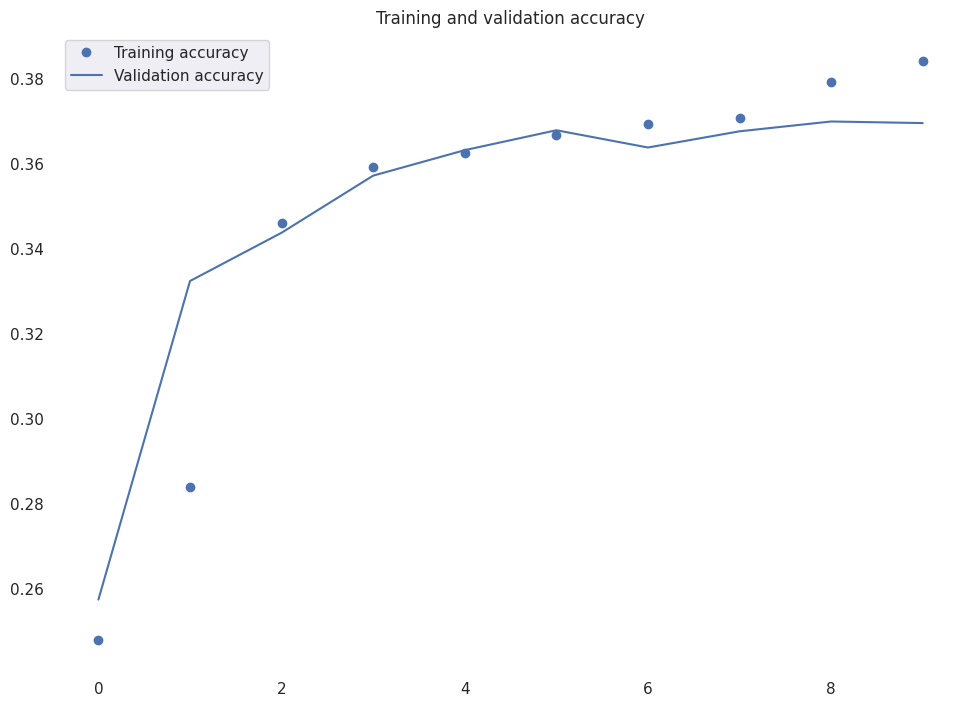

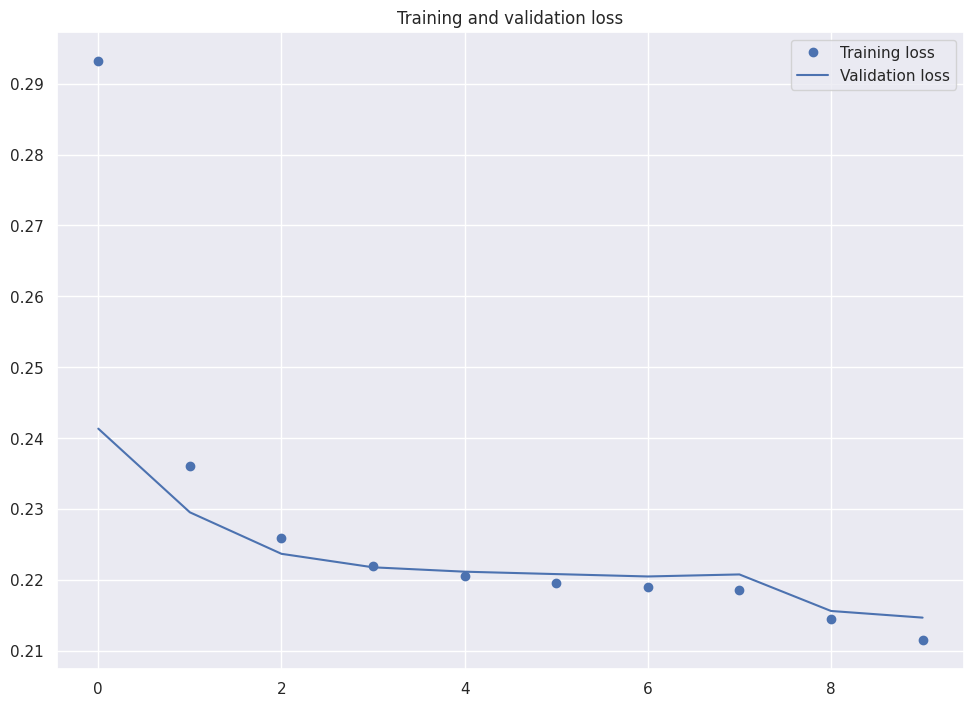


625/625 [==============================] - 1s 2ms/step
Element Count
10    19993
dtype: int64


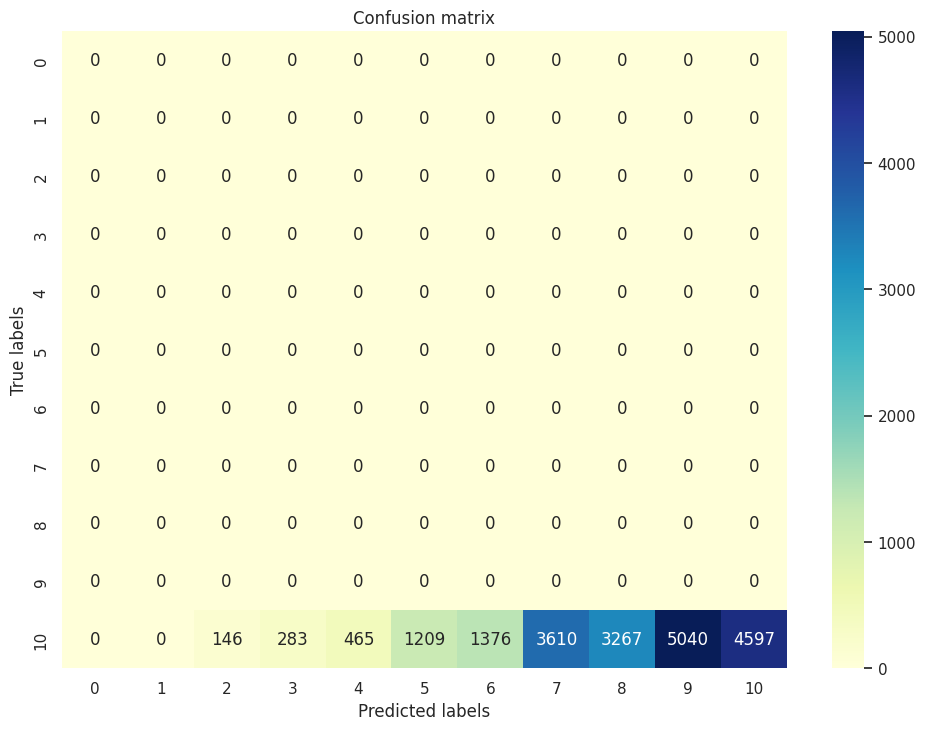

In [ ]:
model_transform(model_2, 'Neural network with dropout and different number of neurons')

# Model 3 - LSTM

In [ ]:
# Architecture
model5 = Sequential()
model5.add(Dense(8, activation="relu", input_shape = (X1_train_prepared.shape[1], )))
model5.add(Dense(4, activation="relu"))
model5.add(Dropout(0.2))
model5.add(Flatten())

model6 = Sequential()
embedding_layer = Embedding(max_features, 4, input_length = maxlen, trainable = True)
model6.add(embedding_layer)
model6.add(LSTM(8, activation="relu", input_shape = (10,)))
model6.add(Dropout(0.2))
model6.add(Flatten())

combinedInput = keras.layers.concatenate([model5.output, model6.output])
x = Dense(4, activation="relu")(combinedInput)
x = Dense(11, activation="softmax")(x)
model_3 = Model(inputs=[model5.input, model6.input], outputs = x)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_10_input (InputLayer)    [(None, 14)]         0           []                               
                                                                                                  
 embedding_2_input (InputLayer)  [(None, 100)]       0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 8)            120         ['dense_10_input[0][0]']         
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 4)       40000       ['embedding_2_input[0][0]']      
                                                                                            

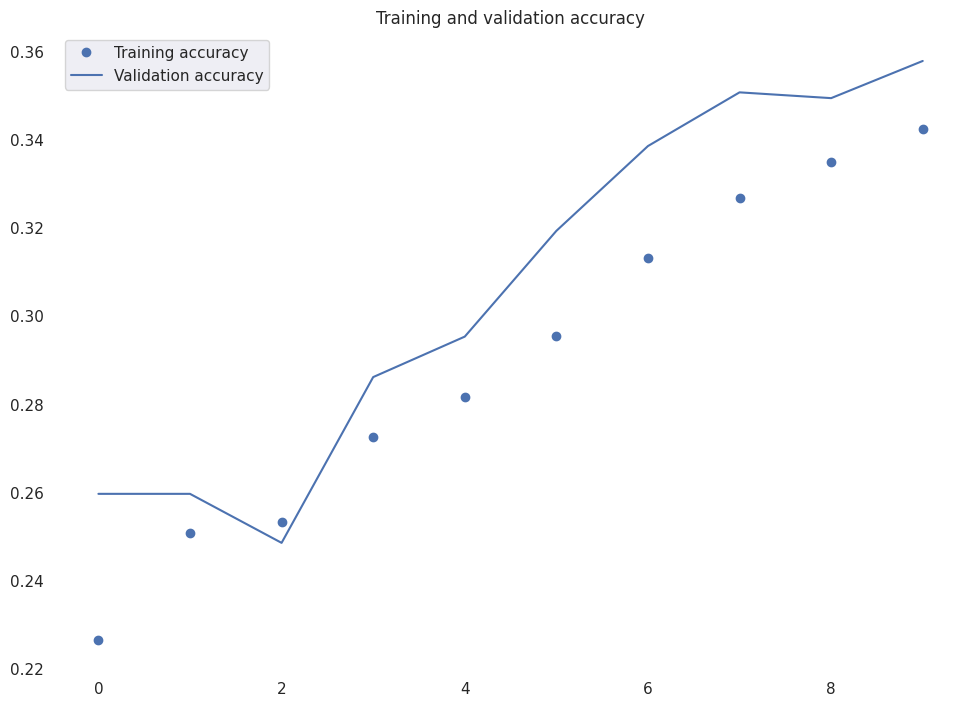

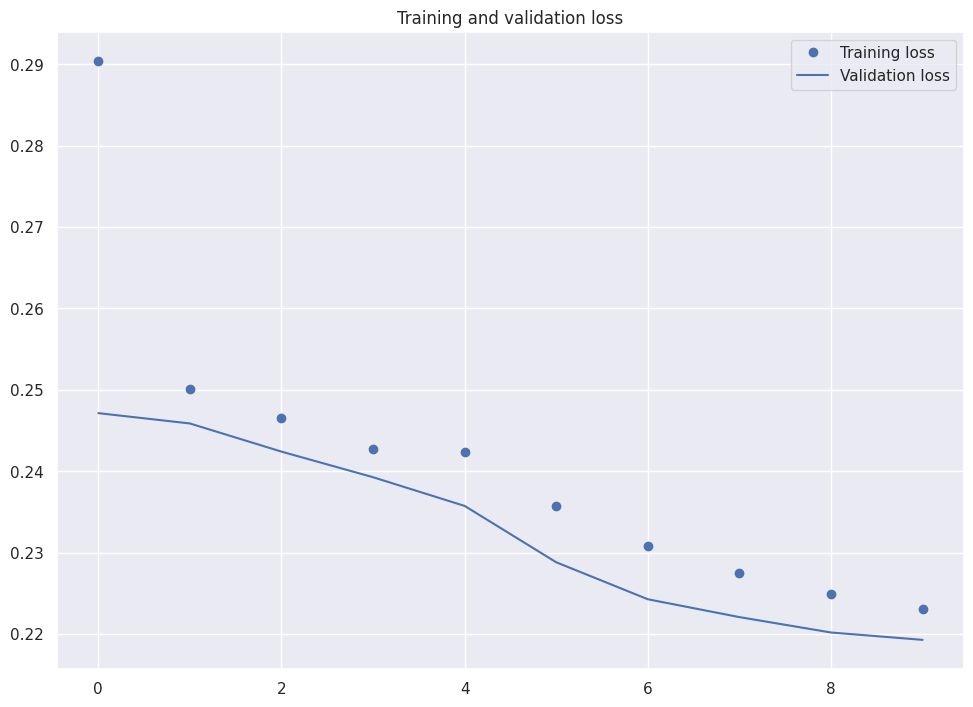


625/625 [==============================] - 10s 16ms/step
Element Count
10    16666
9      2600
7       727
dtype: int64


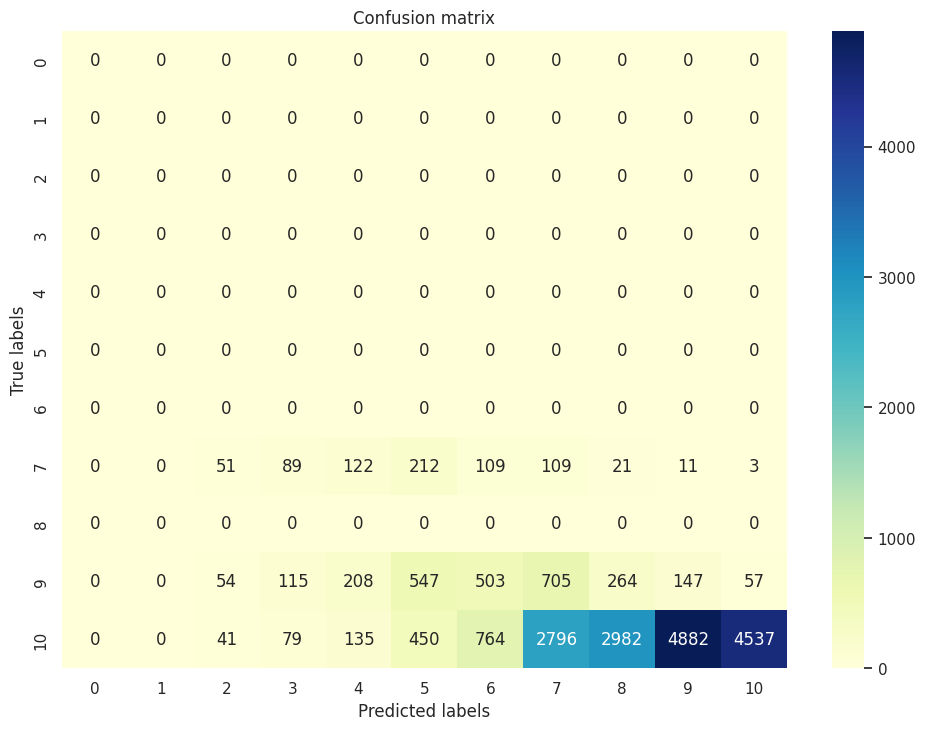

In [ ]:
model_transform(model_3, 'LSTM')

# Model 4 - sigmoid instead of relu


In [ ]:
# Architecture
model7 = Sequential()
model7.add(Dense(8, activation="sigmoid", input_shape = (X1_train_prepared.shape[1], )))
model7.add(Dense(4, activation="sigmoid"))
model7.add(Dropout(0.2))
model7.add(Flatten())

model8 = Sequential()
embedding_layer = Embedding(vocab_length, 4, input_length = maxlen, trainable = True)
model8.add(embedding_layer)
model8.add(LSTM(8, activation="sigmoid", input_shape = (10,)))
model8.add(Dropout(0.2))
model8.add(Flatten())

combinedInput = keras.layers.concatenate([model7.output, model8.output])
x = Dense(4, activation="sigmoid")(combinedInput)
x = Dense(11, activation="softmax")(x)
model_4 = Model(inputs=[model7.input, model8.input], outputs = x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_input (InputLayer)       [(None, 14)]         0           []                               
                                                                                                  
 embedding_input (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 8)            120         ['dense_input[0][0]']            
                                                                                                  
 embedding (Embedding)          (None, 100, 4)       80256       ['embedding_input[0][0]']        
                                                                                              

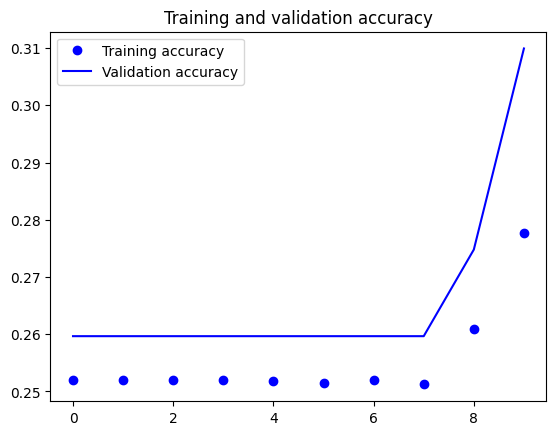

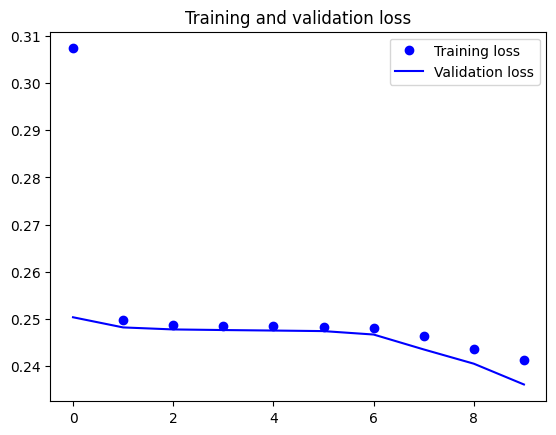


625/625 [==============================] - 6s 10ms/step
Element Count
7    19978
5       15
dtype: int64


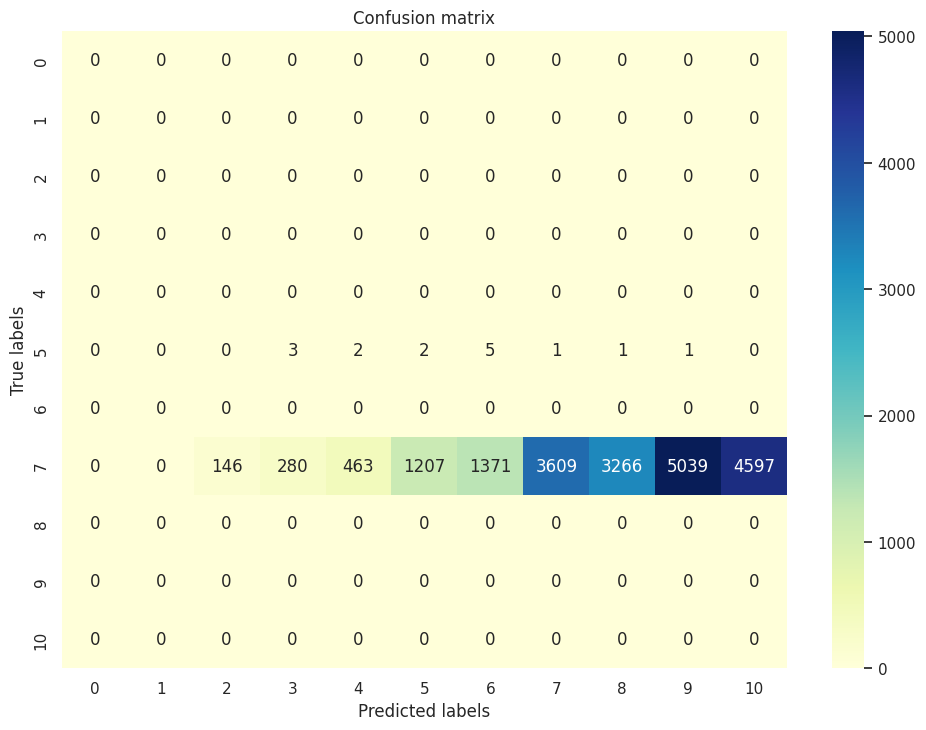

In [ ]:
model_transform(model_4, 'Sigmoid instead of relu')

## **Summary**



*   Model 1 (Simple Neural Network) had the best result for train data (loss: 0.2062 and accuracy: 0.4185).
*   Model 2 (Dropout and different number of neurons) had the best result for validation data (loss: 0.2147 and accuracy: 0.3696).
*  Model 4 (Sigmoid instead of relu) had the best result for test data (loss: 0.2569 and accuracy: 0.1806).
*   Finally, the Model 1 had the best overall results.
*   Due to processing units limitation, it was impossible to train the models for more epochs than 10. Probably, the increase in this parameter will result in better model performances.

# **Test data**

In [95]:
# Load model sigmoid
filename = 'gdrive/My Drive/Sigmoid instead of relu.joblib'
model_sigmoid = load(filename)

In [105]:
# Prediction on test set
pred_sigmoid = model_sigmoid.predict(x = [X1_test_prepared[222:223], X2_test_pad[222:223]])
odp_pred = np.argmax(pred_sigmoid, axis = 1)
count = pd.Series(odp_pred).value_counts()
print("Element  Probability of occurence")
print(count)

1/1 [==============================] - 0s 53ms/step
Element  Probability of occurence
7    1
dtype: int64


In [97]:
# Load simple neural neywork
filename = 'gdrive/My Drive/Simple_neural_network.joblib'
model_simple = load(filename)

In [108]:
# Prediction on test set
pred_simple = model_simple.predict(x = [X1_test_prepared[222:223], X2_test_pad[222:223]])
odp_pred = np.argmax(pred_simple, axis = 1)
count = pd.Series(odp_pred).value_counts()
print("Element  Probability of occurence")
print(count)

1/1 [==============================] - 0s 22ms/step
Element  Probability of occurence
10    1
dtype: int64


In [99]:
# Load model Neural network with dropout and different number of neurons
filename = 'gdrive/My Drive/Neural network with dropout and different number of neurons.joblib'
model_neuron = load(filename)

In [110]:
# Prediction on test set
pred_neuron = model_neuron.predict(x = [X1_test_prepared[222:223], X2_test_pad[222:223]])
odp_pred = np.argmax(pred_neuron, axis = 1)
count = pd.Series(odp_pred).value_counts()
print("Element  Probability of occurence")
print(count)

1/1 [==============================] - 0s 24ms/step
Element  Probability of occurence
10    1
dtype: int64


In [101]:
# Load model LSTM
filename = 'gdrive/My Drive/LSTM.joblib'
model_lstm = load(filename)

In [112]:
# Prediction on test set
pred_lstm = model_lstm.predict(x = [X1_test_prepared[222:223], X2_test_pad[222:223]])
odp_pred = np.argmax(pred_lstm, axis = 1)
count = pd.Series(odp_pred).value_counts()
print("Element  Probability of occurence")
print(count)

1/1 [==============================] - 0s 33ms/step
Element  Probability of occurence
10    1
dtype: int64




*   Model 4 predicts that the reviever score for sample will be between 6 and 7.
*   Rest model predict that the score will be between 9 and 10

